# Hidden Markov Model exploration
Meichen Lu (meichenlu91@gmail.com) 26th April 2018

Based on the health-fever model 
see: https://en.wikipedia.org/wiki/Forward%E2%80%93backward_algorithm
https://en.wikipedia.org/wiki/Viterbi_algorithm

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Specify HMM parameters

# The original python code from wikipedia:
# states = ('Healthy', 'Fever')
# end_state = 'E'
 
# observations = ('normal', 'cold', 'dizzy')
 
# start_probability = {'Healthy': 0.6, 'Fever': 0.4}

# transition_probability = {
#    'Healthy' : {'Healthy': 0.69, 'Fever': 0.3, 'E': 0.01},
#    'Fever' : {'Healthy': 0.4, 'Fever': 0.59, 'E': 0.01},
#    }
 
# emission_probability = {
#    'Healthy' : {'normal': 0.5, 'cold': 0.4, 'dizzy': 0.1},
#    'Fever' : {'normal': 0.1, 'cold': 0.3, 'dizzy': 0.6},
#    }

# Updated python code for easier matrix manipulation
prob_start = np.array([0.6, 0.4])
A = np.array([[0.7, 0.3], [0.4, 0.6]])
# multinomial emission probability model
pe = np.array([[0.5, 0.4, 0.1], [0.1, 0.3, 0.6]])

In [3]:
def fwd_bwd_hmm(X, pi, A, pe):
    '''
    forward backward algorithm for multinomial emission probability model
    For N observations, K latent states, M observed states
    inputs:
        X: (N-by-1) observation
        pi: (K-by-1) initial probability 
        A: (K-by-K) transition matrices
        pe: (K-by-M) emission probability
    return a dictinoary with fields:
        alpha & beta: (N-by-K) intermediate variables
        gamma: (N-by-K) conditional probability of z_n
        xi:(N-by-K-by-K) conditional probability of z_n
    '''
    # Find basic information
    N = np.size(X)
    M = np.shape(pe)[0]
    K = np.shape(A)[0]
    
    # Initialise intermediate & return variables
    alpha = np.zeros((N, K))
    beta = np.zeros((N, K))
    gamma = np.zeros((N, K))
    xi = np.zeros((N-1, K, K))
    
    # Initial alpha & beta
    alpha[0] = pi * pe[:,int(X[0])]
    beta[N-1] = 1
    for i in range(1,N):
        # update alpha
        xn = int(X[i])
        for k in range(K):
            alpha[i,k] = np.sum(alpha[i-1,:] * A[:,k]) * pe[k,xn]
        # update beta
        xn_rev = int(X[N-i-1])
        for k in range(K):
            beta[N-i-1,k] = np.sum(beta[N-i,:]*pe[:,xn_rev]*A[k,:])
    
    # Summing things up to get posterior probability
    gamma = alpha*beta
    # Marginal probability P(X)
    P_X = np.sum(gamma,axis = 1)
    gamma = gamma/P_X[:,np.newaxis]
    
    # Find the other posterior probability (of z_{n-1}, z_n)
    for i in range(N-1):
        xn = int(X[i+1])
        for k1 in range(K):
            for k2 in range(K):
                xi[i, k1, k2] = alpha[i,k1] * pe[k2,xn] * A[k1, k2] * beta[i+1, k2]
        xi[i] = xi[i]/np.sum(xi[i])
    
    fwd_bwd = {'alpha': alpha, 'beta': beta, 'gamma': gamma, 'xi': xi}
    
    return fwd_bwd
        

In [4]:
# Code up an example
X = np.array([0,1,2])
fwd_bwd = fwd_bwd_hmm(X, prob_start, A, pe)
print(fwd_bwd['gamma'])

[[ 0.91734886  0.08265114]
 [ 0.74203567  0.25796433]
 [ 0.21212789  0.78787211]]


In [5]:
print(fwd_bwd['xi'])

[[[ 0.68950217  0.20365605]
  [ 0.0525335   0.05430828]]

 [[ 0.17442117  0.44851158]
  [ 0.03770673  0.33936053]]]


## Viterbi algorithm to find the optimal path

In [6]:
# Implementation according to wikipedia
def viterbi(X, pi, A, pe):
    '''
    Inputs are the same as before
    return a dictinoary with fields (see wikipedia for explanations):
        T1: (N-by-K) 
        T2: (N-by-K)
    '''
    # Find basic information
    N = np.size(X)
    M = np.shape(pe)[0]
    K = np.shape(A)[0]
    
    # Initialise intermediate & return variables
    T1 = np.zeros((N, K))
    T2 = np.zeros((N, K))
    
    T1[0] = pi * pe[:,X[0]]
    
    for i in range(1,N):
        xn = X[i]
        for k in range(K):
            temp = T1[i-1,:]*A[:,k]*pe[k,xn]
            T1[i,k] = np.max(temp)
            T2[i,k] = np.argmax(temp)
            
    opt_path = {'T1' : T1, 'T2' : T2}
    return opt_path
    

In [7]:
X = np.array([0,1,2])
opt_path = viterbi(X, prob_start, A, pe)
print(opt_path['T1'])
print(opt_path['T2'])

[[ 0.3      0.04   ]
 [ 0.084    0.027  ]
 [ 0.00588  0.01512]]
[[ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]]


## HMM multinomial parameters learning

In [8]:
# Generate the data
prob_start = np.array([1, 0.0])
A = np.array([[0.8, 0.2], [0.2, 0.8]])
# multinomial emission probability model
pe = np.array([[0.9, 0.1], [0.3, 0.7]])
N = 100
Z = np.zeros((100))
X = np.zeros(100)
for i in range(N):
    if i < 1:
        hidden_state = np.random.choice(2, p = prob_start)
    else:
        hidden_state = np.random.choice(2, p=A[hidden_state])
    Z[i] = hidden_state
    X[i] = np.random.choice(2, p=pe[hidden_state])

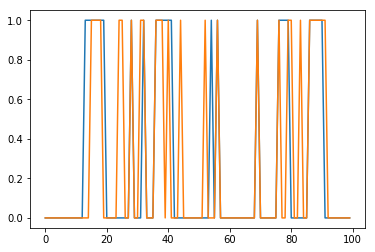

In [9]:
plt.plot(Z)
plt.plot(X)

Steps for learning
1. Initialise the variables $pi, A, pe$
2. Conduct EM until convergence

In [10]:
# Initialise variables
# pi2 = np.random.rand(2)
# pi2 = pi2/np.sum(pi2)
pi2 = [0.5,0.5]
A2 = np.random.rand(2,2)
A2 = A2/np.sum(A2, axis = 0)
A2 = A2.T
pe2 = np.random.rand(2,2)
pe2 = pe2/np.sum(pe2, axis = 0)
pe2 = pe2.T

In [11]:
# EM
tol = 1
pe_hist = pe2.reshape((pe2.size, -1))
iter = 0
while tol>1e-4 and iter < 500:
    # E-step: compute posterior distribution
    fwd_bwd = fwd_bwd_hmm(X, pi2, A2, pe2)
    # M-step: update variables
    gamma = fwd_bwd['gamma']
    xi = fwd_bwd['xi']
    pi2 = gamma[0]
    for j in range(2):
        for k in range(2):
            A2[j,k] = np.sum(xi[:,j,k])/np.sum(xi[:,j,:])
    for k in range(2):
        for i in range(2):
            pe2[k,i] = np.sum(gamma[:,k]*(X==i))/np.sum(gamma[:,k])
    pe_lin = pe2.reshape((pe2.size, -1))
    tol = np.linalg.norm(pe_hist - pe_lin)
    pe_hist = pe_lin
    iter += 1

In [12]:
pe

array([[ 0.9,  0.1],
       [ 0.3,  0.7]])

In [13]:
pe2

array([[  9.99999998e-01,   1.79130508e-09],
       [  1.05824035e-04,   9.99894176e-01]])

In [14]:
A2

array([[ 0.80554686,  0.19445314],
       [ 0.51847878,  0.48152122]])

In [15]:
pi2

array([  1.00000000e+00,   4.35002175e-46])

Question: why does the learning fail? 

Guesses: (1) This is an ill-posed problem and the emission probabilities cannot be distinguished from the transition probabilities. (2) More starting points are needed as the system will reach an equilibrium (however, even if we use the same starting probability as 1 in one of the class, the learning still fails.

P.S. Final check that the posterior probabilities are correct.
The two graphs show that $\eta(z_{n-1}, z_n)$ predicts the transition between the two hidden states (depicted by the posterior probability evolution $\gamma(z_n)$ in orange and blue lines)

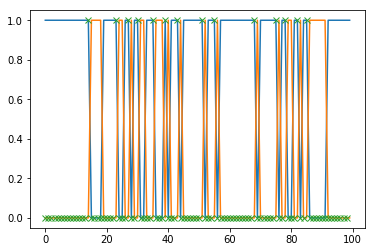

In [16]:
plt.plot(gamma)
plt.plot(xi[:,0,1],'x')

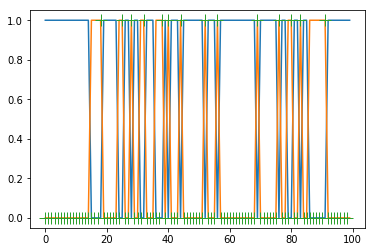

In [19]:
plt.plot(gamma)
plt.plot(xi[:,1,0],'+',markersize=12)

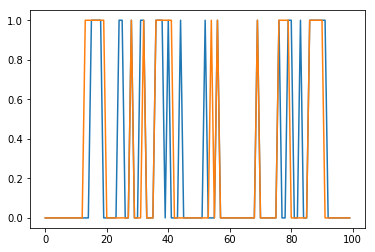

In [28]:
plt.plot(gamma[:,1])
plt.plot(Z)